In [1]:
# Install required libraries
!pip install scikit-image opencv-python-headless tensorflow


from google.colab import drive

data_dir = '/content/drive/MyDrive/MLDATA/data'


In [2]:
import os
import cv2
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

def load_images_and_labels(data_dir, img_size=(64, 64)):
    images, labels = [], []
    folders = [d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))]
    for label in folders:
        class_dir = os.path.join(data_dir, label)
        for i, img_name in enumerate(os.listdir(class_dir)):
            img_path = os.path.join(class_dir, img_name)
            img = cv2.imread(img_path)
            if img is not None:
                img = cv2.resize(img, img_size)
                images.append(img)
                labels.append(label)
    return np.array(images), np.array(labels)

# ~1500 images for SVM, rest for NN
MAX_SVM = 1500
data_dir = '/content/drive/MyDrive/MLDATA/data'
X_all, y_all = load_images_and_labels(data_dir, img_size=(64, 64))
le = LabelEncoder()
y_encoded = le.fit_transform(y_all)
X_all = X_all.astype('float32') / 255.0

# For SVM limiting to 1500 samples
X_small, y_small = X_all[:MAX_SVM], y_encoded[:MAX_SVM]
X_train, X_temp, y_train, y_temp = train_test_split(X_all, y_encoded, test_size=0.3, stratify=y_encoded, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)


In [5]:
from skimage.feature import hog
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
import numpy as np
import cv2

def extract_hog_features_fast(images):
    feat_list = []
    for img in images:
        gray = cv2.cvtColor((img * 255).astype('uint8'), cv2.COLOR_BGR2GRAY)
        # Simpler HOG for speed, fewer features:
        features = hog(gray, pixels_per_cell=(8,8), cells_per_block=(2,2), feature_vector=True)
        feat_list.append(features)
    return np.array(feat_list)

X_svm_hog = extract_hog_features_fast(X_small)
svm = SVC(kernel='linear', max_iter=1500)
svm.fit(X_svm_hog, y_small)
y_pred_svm = svm.predict(X_svm_hog)
print("SVM Accuracy (subsample):", accuracy_score(y_small, y_pred_svm))

# Get the unique labels present in the small subsample
unique_labels_small = np.unique(y_small)
# Get the corresponding target names for these labels
target_names_small = le.inverse_transform(unique_labels_small)

print(classification_report(y_small, y_pred_svm, labels=unique_labels_small, target_names=target_names_small))

/usr/local/lib/python3.12/dist-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


SVM Accuracy (subsample): 1.0
                       precision    recall  f1-score   support

 Potato___Late_blight       1.00      1.00      1.00      1000
Tomato_Bacterial_spot       1.00      1.00      1.00       500

             accuracy                           1.00      1500
            macro avg       1.00      1.00      1.00      1500
         weighted avg       1.00      1.00      1.00      1500



In [6]:
import tensorflow as tf
from tensorflow.keras import layers, models

num_classes = len(le.classes_)

model_cnn = models.Sequential([
    layers.Conv2D(16, (3,3), activation='relu', input_shape=(64,64,3)),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(32, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
])

model_cnn.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

history = model_cnn.fit(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_val, y_val))
test_loss, test_acc = model_cnn.evaluate(X_test, y_test)
print("CNN Test Accuracy:", test_acc)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
398/398 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.3616 - loss: 1.8991 - val_accuracy: 0.7385 - val_loss: 0.7803
Epoch 2/5
398/398 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7444 - loss: 0.7597 - val_accuracy: 0.8042 - val_loss: 0.5677
Epoch 3/5
398/398 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8013 - loss: 0.5704 - val_accuracy: 0.8254 - val_loss: 0.5125
Epoch 4/5
398/398 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8461 - loss: 0.4489 - val_accuracy: 0.8298 - val_loss: 0.4962
Epoch 5/5
398/398 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8672 - loss: 0.3844 - val_accuracy: 0.8555 - val_loss: 0.3972
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8494 - loss: 0.4423
CNN Test Accuracy: 0.8404840230941772


In [7]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model

base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(64,64,3))
base_model.trainable = False

x = GlobalAveragePooling2D()(base_model.output)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(num_classes, activation='softmax')(x)
model_resnet = Model(inputs=base_model.input, outputs=outputs)

model_resnet.compile(optimizer='adam',
                     loss='sparse_categorical_crossentropy',
                     metrics=['accuracy'])

history_res = model_resnet.fit(X_train, y_train, epochs=3, batch_size=32, validation_data=(X_val, y_val))
test_loss2, test_acc2 = model_resnet.evaluate(X_test, y_test)
print("ResNet50 Test Accuracy:", test_acc2)


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
Epoch 1/3
398/398 ━━━━━━━━━━━━━━━━━━━━ 30s 46ms/step - accuracy: 0.1632 - loss: 2.4396 - val_accuracy: 0.2369 - val_loss: 2.2371
Epoch 2/3
398/398 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.2420 - loss: 2.2542 - val_accuracy: 0.2780 - val_loss: 2.1245
Epoch 3/3
398/398 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - accuracy: 0.2898 - loss: 2.1452 - val_accuracy: 0.3517 - val_loss: 2.0098
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.3449 - loss: 2.0116
ResNet50 Test Accuracy: 0.3351668417453766


SVM Classification Report:
                       precision    recall  f1-score   support

 Potato___Late_blight       1.00      1.00      1.00      1000
Tomato_Bacterial_spot       1.00      1.00      1.00       500

             accuracy                           1.00      1500
            macro avg       1.00      1.00      1.00      1500
         weighted avg       1.00      1.00      1.00      1500

86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
CNN Classification Report:
                                             precision    recall  f1-score   support

                      Potato___Early_blight       0.95      0.87      0.91       152
                       Potato___Late_blight       0.81      0.73      0.77       150
                           Potato___healthy       1.00      0.65      0.79        23
                      Tomato_Bacterial_spot       0.97      0.84      0.90       319
                        Tomato_Early_blight       0.78      0.43      0.55       150
               

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


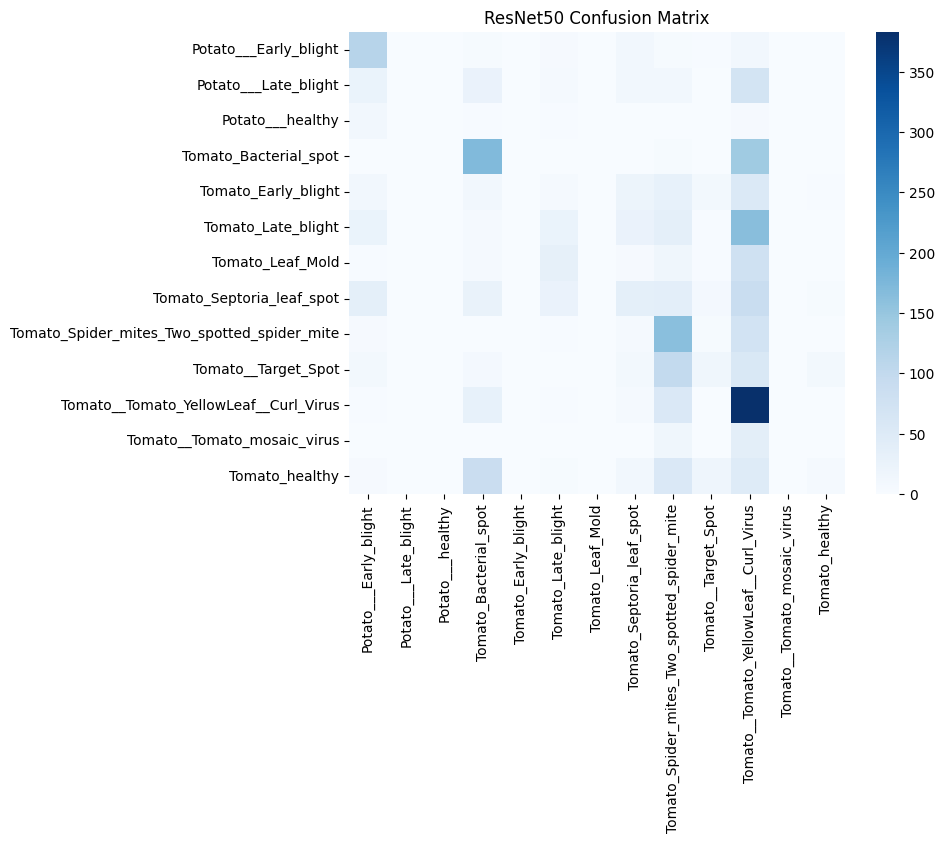

In [10]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# SVM Report
print("SVM Classification Report:")
# Use y_small and y_pred_svm for the SVM report
print(classification_report(y_small, y_pred_svm, target_names=le.inverse_transform(np.unique(y_small))))


# CNN
y_pred_cnn = model_cnn.predict(X_test).argmax(axis=1)
print("CNN Classification Report:")
print(classification_report(y_test, y_pred_cnn, target_names=le.classes_))

# ResNet50
y_pred_resnet = model_resnet.predict(X_test).argmax(axis=1)
print("ResNet50 Classification Report:")
print(classification_report(y_test, y_pred_resnet, target_names=le.classes_))

# Confusion Matrix (ResNet50 example):
cm = confusion_matrix(y_test, y_pred_resnet)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=False, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("ResNet50 Confusion Matrix")
plt.show()

In [12]:
# 1. Install required packages in Colab
!pip install -q scikit-image opencv-python-headless tensorflow seaborn

# 2. Mount Google Drive if needed
from google.colab import drive


# 3. Imports and utilities
import os
import cv2
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

def load_images_and_labels(data_dir, img_size=(64, 64)):
    images, labels = [], []
    for label in sorted(os.listdir(data_dir)):
        folder_path = os.path.join(data_dir, label)
        if not os.path.isdir(folder_path):
            continue
        for img_name in sorted(os.listdir(folder_path)):
            img_path = os.path.join(folder_path, img_name)
            img = cv2.imread(img_path)
            if img is None:
                continue
            img = cv2.resize(img, img_size)
            images.append(img)
            labels.append(label)
    return np.array(images), np.array(labels)

data_dir = "/content/drive/MyDrive/MLDATA/data"  # Change as per your setup
X, y = load_images_and_labels(data_dir)
print(f"Loaded {X.shape[0]} images from {len(np.unique(y))} classes")

# Encode labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Normalize images
X_norm = X.astype('float32') / 255.0

# Split dataset (70% train, 15% val, 15% test), stratified
X_train, X_temp, y_train, y_temp = train_test_split(X_norm, y_encoded, stratify=y_encoded, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, stratify=y_temp, test_size=0.5, random_state=42)
print(f"Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")

# 4. SVM + HOG (on small balanced subset to save resources)
from skimage.feature import hog
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

def extract_hog_features(images):
    features = []
    for img in images:
        gray = cv2.cvtColor((img * 255).astype('uint8'), cv2.COLOR_BGR2GRAY)
        feat = hog(gray, pixels_per_cell=(8,8), cells_per_block=(2,2), feature_vector=True)
        features.append(feat)
    return np.array(features)

# Use subsample for SVM (balanced stratified optional)
svm_sample_size = 1500
X_svm = X_train[:svm_sample_size]
y_svm = y_train[:svm_sample_size]

X_svm_hog = extract_hog_features(X_svm)
svm_clf = SVC(kernel='linear', max_iter=2000)
svm_clf.fit(X_svm_hog, y_svm)
X_test_hog = extract_hog_features(X_test)
y_pred_svm = svm_clf.predict(X_test_hog)
print("SVM Accuracy:", accuracy_score(y_test, y_pred_svm))
print("SVM Classification Report:\n", classification_report(y_test, y_pred_svm, target_names=le.classes_))

# 5. CNN model (efficient for 64x64 images)
import tensorflow as tf
from tensorflow.keras import layers, models

num_classes = len(le.classes_)
model_cnn = models.Sequential([
    layers.Conv2D(16, (3,3), activation='relu', input_shape=(64,64,3)),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(32, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
])

model_cnn.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = model_cnn.fit(X_train, y_train, epochs=7, batch_size=32, validation_data=(X_val, y_val))
cnn_loss, cnn_acc = model_cnn.evaluate(X_test, y_test)
print("CNN Test Accuracy:", cnn_acc)

# 6. Transfer learning (ResNet50)
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model

base_model = ResNet50(weights="imagenet", include_top=False, input_shape=(64,64,3))
base_model.trainable = False
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(num_classes, activation='softmax')(x)
model_resnet = Model(base_model.input, outputs)

model_resnet.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history2 = model_resnet.fit(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_val, y_val))
resnet_loss, resnet_acc = model_resnet.evaluate(X_test, y_test)
print("ResNet50 Test Accuracy:", resnet_acc)


Loaded 18179 images from 13 classes
Train: (12725, 64, 64, 3), Val: (2727, 64, 64, 3), Test: (2727, 64, 64, 3)
SVM Accuracy: 0.4998166483314998
SVM Classification Report:
                                              precision    recall  f1-score   support

                      Potato___Early_blight       0.59      0.62      0.61       152
                       Potato___Late_blight       0.50      0.51      0.50       150
                           Potato___healthy       0.00      0.00      0.00        23
                      Tomato_Bacterial_spot       0.50      0.64      0.56       319
                        Tomato_Early_blight       0.11      0.08      0.09       150
                         Tomato_Late_blight       0.48      0.53      0.51       286
                           Tomato_Leaf_Mold       0.54      0.53      0.54       143
                  Tomato_Septoria_leaf_spot       0.28      0.29      0.28       266
Tomato_Spider_mites_Two_spotted_spider_mite       0.57      0.

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/7
398/398 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - accuracy: 0.3451 - loss: 1.9681 - val_accuracy: 0.7316 - val_loss: 0.8395
Epoch 2/7
398/398 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7288 - loss: 0.8011 - val_accuracy: 0.7965 - val_loss: 0.6108
Epoch 3/7
398/398 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8087 - loss: 0.5528 - val_accuracy: 0.8122 - val_loss: 0.5505
Epoch 4/7
398/398 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8436 - loss: 0.4535 - val_accuracy: 0.8603 - val_loss: 0.4232
Epoch 5/7
398/398 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8776 - loss: 0.3549 - val_accuracy: 0.8445 - val_loss: 0.4382
Epoch 6/7
398/398 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8848 - loss: 0.3337 - val_accuracy: 0.8530 - val_loss: 0.4332
Epoch 7/7
398/398 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9056 - loss: 0.2709 - val_accuracy: 0.8724 - val_loss: 0.3789
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8864 - loss: 0.3485
CNN Test Accuracy: 0.8793545961380005